In [3]:
import os
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3
from keras.applications import VGG16

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# Read and Analyse Data

In [4]:
def loading_the_data(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            
            filepaths.append(fpath)
            labels.append(fold)

    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)
    
    return df

In [5]:
data_dir = '/kaggle/input/tomatoleaf/tomato/train'
df = loading_the_data(data_dir)

df

filepaths  \
0     /kaggle/input/tomatoleaf/tomato/train/Tomato__...   
1     /kaggle/input/tomatoleaf/tomato/train/Tomato__...   
2     /kaggle/input/tomatoleaf/tomato/train/Tomato__...   
3     /kaggle/input/tomatoleaf/tomato/train/Tomato__...   
4     /kaggle/input/tomatoleaf/tomato/train/Tomato__...   
...                                                 ...   
9995  /kaggle/input/tomatoleaf/tomato/train/Tomato__...   
9996  /kaggle/input/tomatoleaf/tomato/train/Tomato__...   
9997  /kaggle/input/tomatoleaf/tomato/train/Tomato__...   
9998  /kaggle/input/tomatoleaf/tomato/train/Tomato__...   
9999  /kaggle/input/tomatoleaf/tomato/train/Tomato__...   

                                             labels  
0                              Tomato___Late_blight  
1                              Tomato___Late_blight  
2                              Tomato___Late_blight  
3                              Tomato___Late_blight  
4                              Tomato___Late_blight  
...                                             ...  
9995  Tomato___Spider_mites Two-spotted_spider_mite  
9996  Tomato___Spider_mites Two-spotted_spider_mite  
9997  Tomato___Spider_mites Two-spotted_spider_mite  
9998  Tomato___Spider_mites Two-spotted_spider_mite  
9999  Tomato___Spider_mites Two-spotted_spider_mite  

[10000 rows x 2 columns]

In [6]:
data_balance = df.labels.value_counts()
data_balance

labels
Tomato___Late_blight                             1000
Tomato___healthy                                 1000
Tomato___Early_blight                            1000
Tomato___Septoria_leaf_spot                      1000
Tomato___Tomato_Yellow_Leaf_Curl_Virus           1000
Tomato___Bacterial_spot                          1000
Tomato___Target_Spot                             1000
Tomato___Tomato_mosaic_virus                     1000
Tomato___Leaf_Mold                               1000
Tomato___Spider_mites Two-spotted_spider_mite    1000
Name: count, dtype: int64

In [53]:
def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


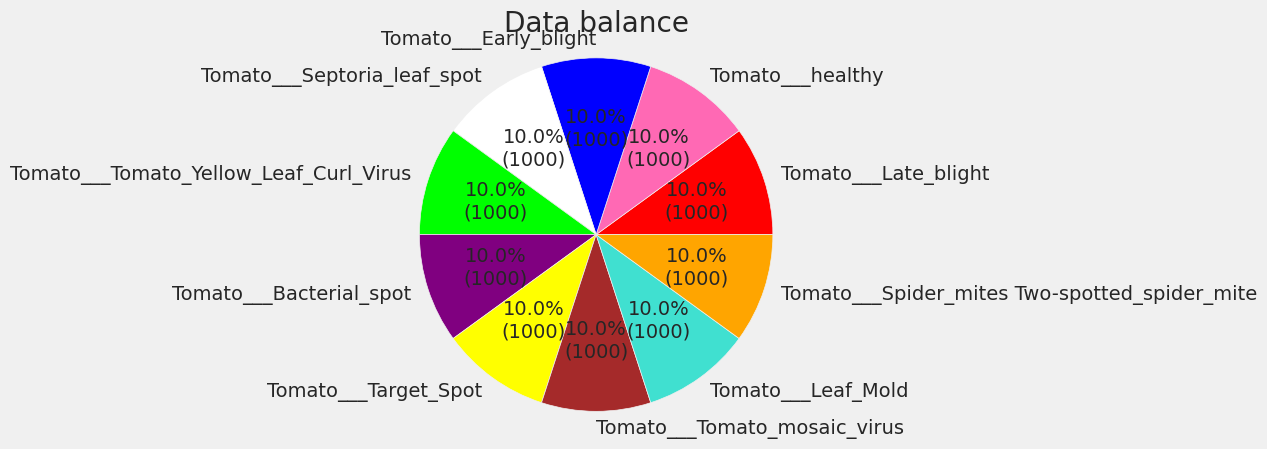

In [54]:
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#FF0000", "#FF69B4", "#0000FF", "#FFFFFF", "#00FF00", "#800080", "#FFFF00", "#A52A2A", "#40E0D0", "#FFA500"])
plt.title("Data balance")
plt.axis("equal")
plt.show()

# Helper Functions

In [8]:
def model_performance(history, Epochs):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    
    Epochs = [i+1 for i in range(len(tr_acc))]
    
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()

In [9]:
def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)
    
    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])

In [10]:
def get_pred(model, test_gen):
    
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis = 1)
    
    return y_pred


In [11]:
def plot_confusion_matrix(test_gen, y_pred):
    
    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())
    
    cm = confusion_matrix(test_gen.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45, fontsize=8)  
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.show()

In [12]:
def conv_block(filters, act='relu'):
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPooling2D())
    
    return block

In [13]:
def dense_block(units, dropout_rate, act='relu'):
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

# Train - Test Split

In [14]:
train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)

valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

In [17]:
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)


train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 8000 validated image filenames belonging to 10 classes.
Found 1000 validated image filenames belonging to 10 classes.
Found 1000 validated image filenames belonging to 10 classes.


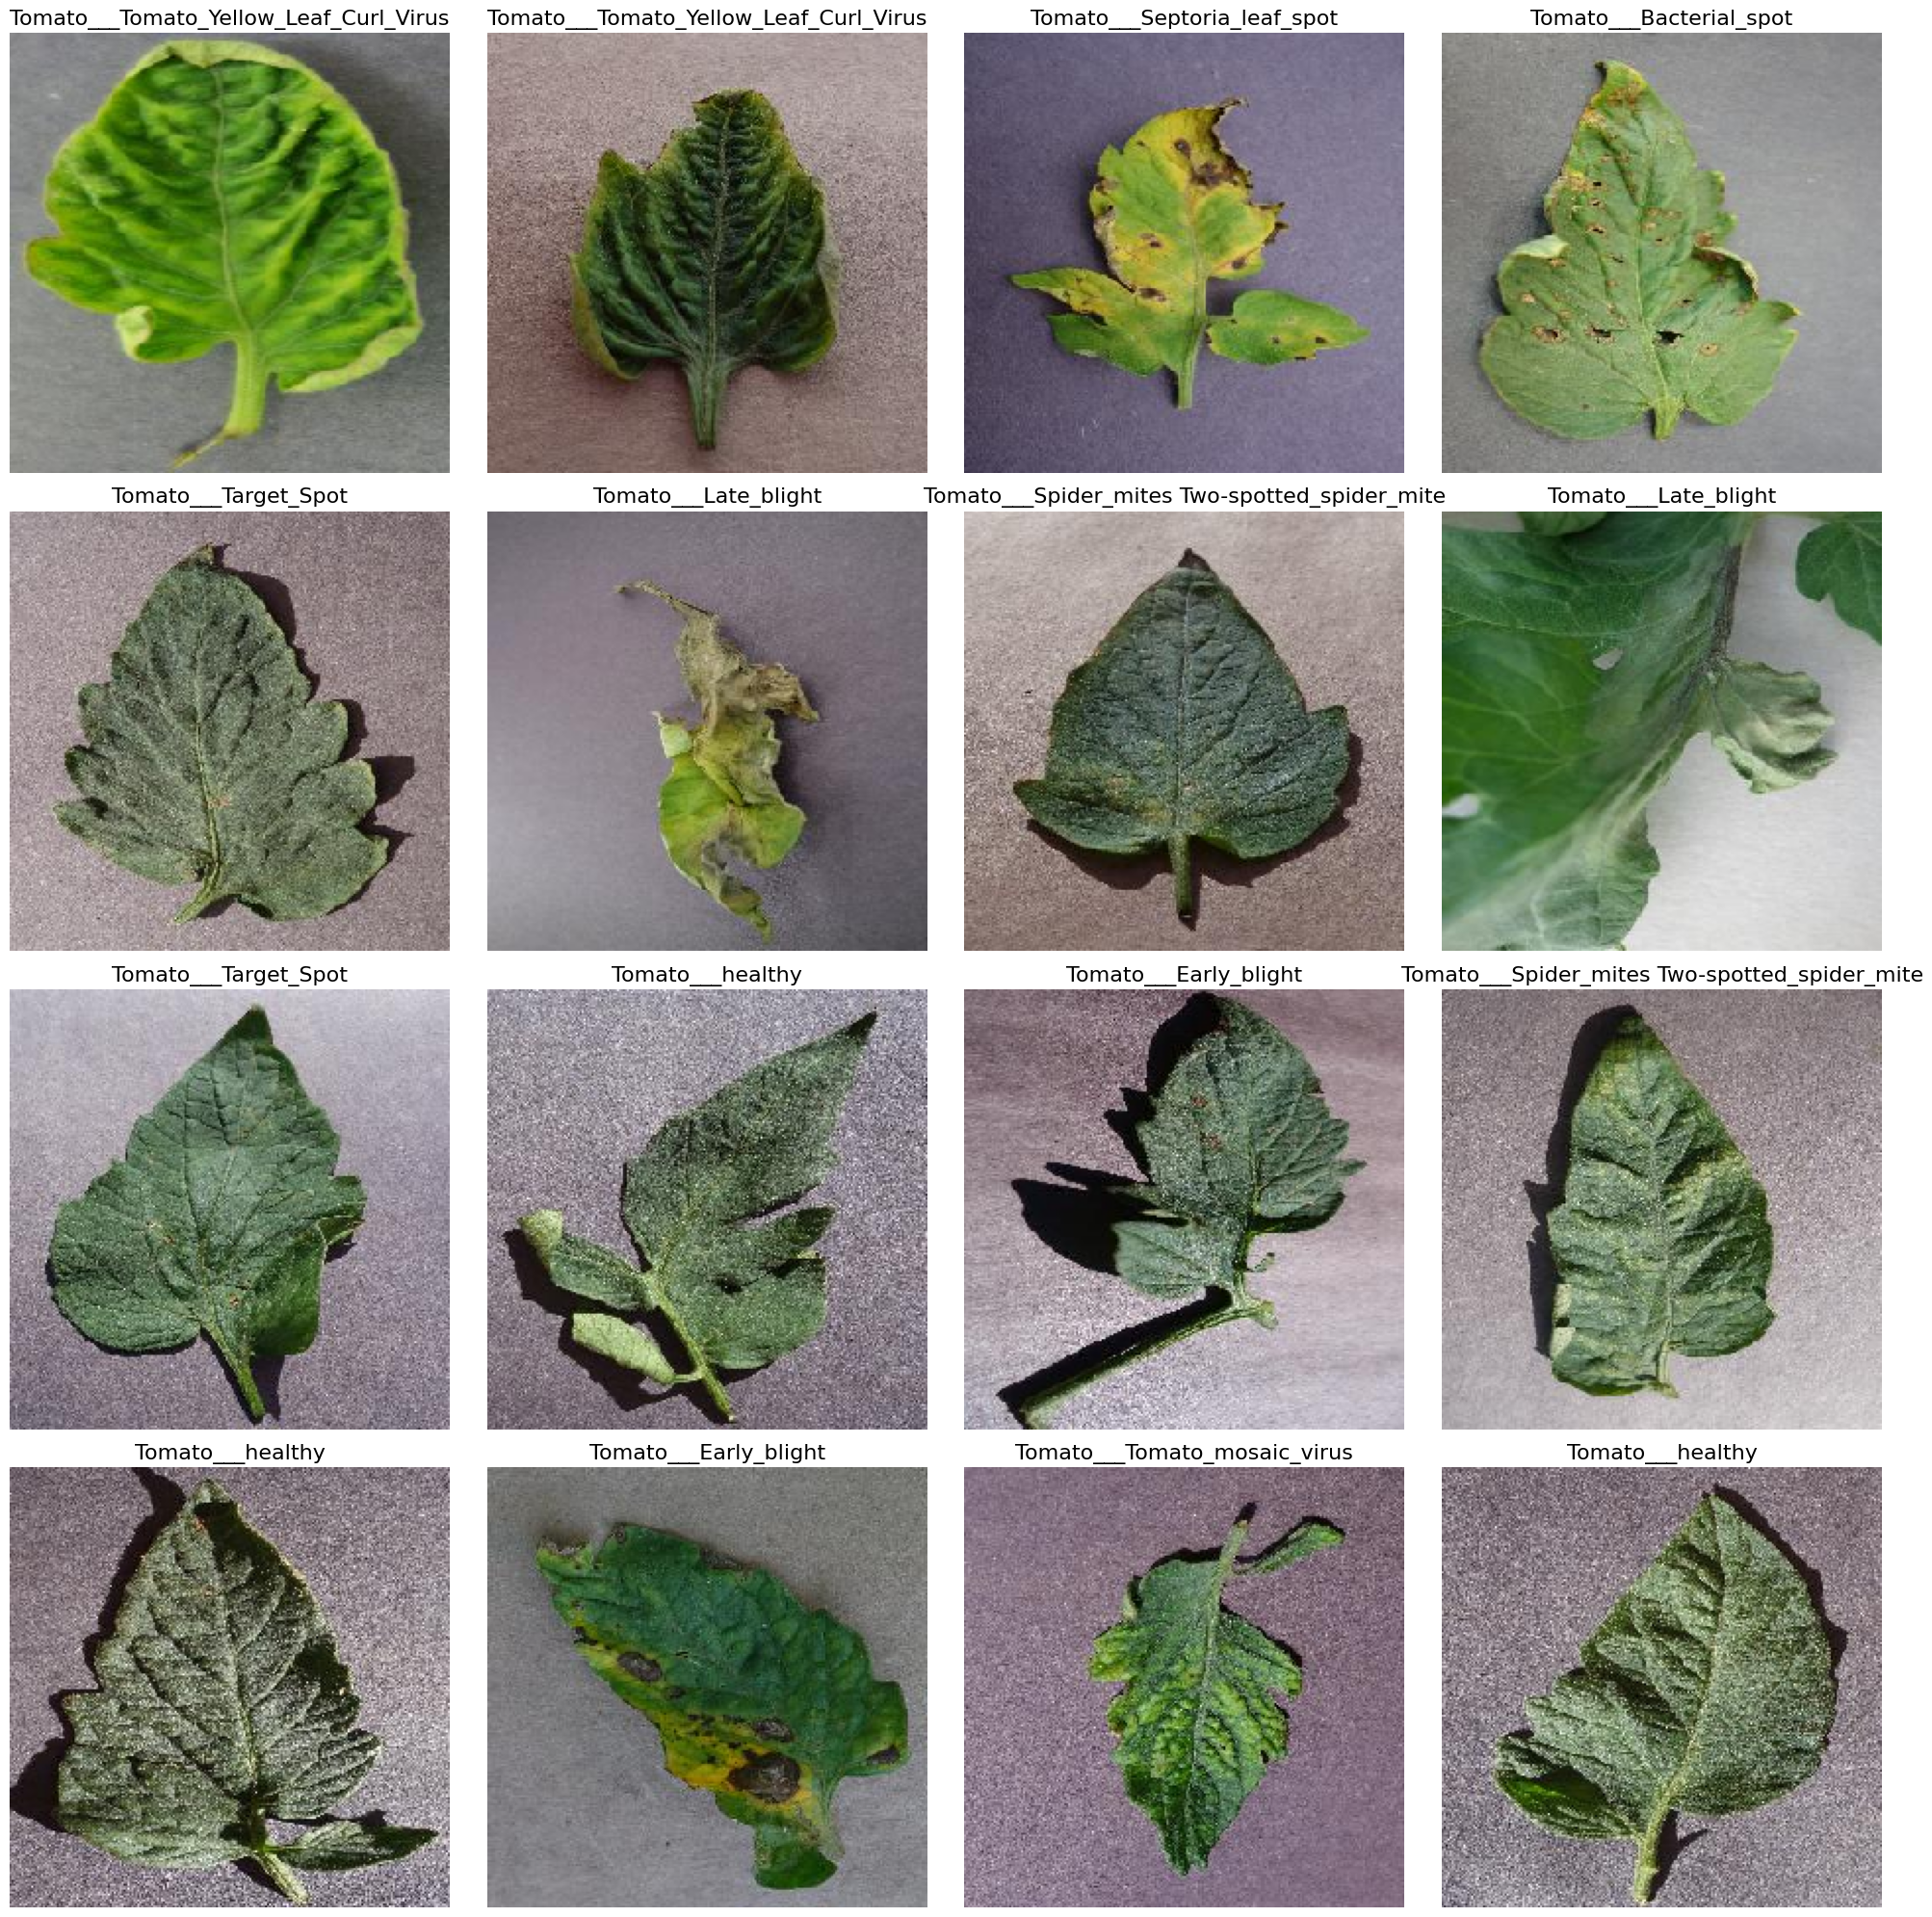

In [18]:
g_dict = train_gen.class_indices     
classes = list(g_dict.keys())       
images, labels = next(train_gen)      

# ploting the patch size samples
plt.figure(figsize= (20, 20))

for i in range(batch_size):
    plt.subplot(4, 4, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

# CNN Model

In [19]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_counts = len(list(train_gen.class_indices.keys()))

In [20]:
cnn_model = Sequential()

cnn_model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D())

cnn_model.add(conv_block(32))

cnn_model.add(conv_block(64))

cnn_model.add(conv_block(128))

cnn_model.add(conv_block(256))

cnn_model.add(conv_block(512))

cnn_model.add(Flatten())

cnn_model.add(dense_block(256, 0.5))

cnn_model.add(dense_block(128, 0.3))

cnn_model.add(dense_block(64, 0.2))

cnn_model.add(dense_block(32, 0.2))

cnn_model.add(Dense(class_counts, activation = "softmax"))

In [21]:
cnn_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 56, 56, 32)     │        14,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 28, 28, 64)     │        55,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 14, 14, 128)    │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 7, 7, 256)      │       886,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 3, 3, 512)      │     3,542,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 256)            │     1,180,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 128)            │        33,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_8 (Sequential)       │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (None, 32)             │         2,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,945,834 (22.68 MB)

 Trainable params: 5,942,858 (22.67 MB)

 Non-trainable params: 2,976 (11.62 KB)

In [22]:
epochs = 20   

history = cnn_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/20
  2/500 ━━━━━━━━━━━━━━━━━━━━ 27s 55ms/step - accuracy: 0.0781 - loss: 3.0894   

I0000 00:00:1738847867.598235      91 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1738847867.624915      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.1933 - loss: 2.5136

W0000 00:00:1738847927.009790      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


500/500 ━━━━━━━━━━━━━━━━━━━━ 99s 140ms/step - accuracy: 0.1934 - loss: 2.5131 - val_accuracy: 0.1380 - val_loss: 2.4946
Epoch 2/20
  2/500 ━━━━━━━━━━━━━━━━━━━━ 27s 55ms/step - accuracy: 0.3125 - loss: 1.7725 

W0000 00:00:1738847937.540400      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 66ms/step - accuracy: 0.3561 - loss: 1.8518 - val_accuracy: 0.3870 - val_loss: 1.8467
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 68ms/step - accuracy: 0.4335 - loss: 1.6252 - val_accuracy: 0.5640 - val_loss: 1.3272
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 66ms/step - accuracy: 0.5269 - loss: 1.3839 - val_accuracy: 0.6680 - val_loss: 0.9982
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 36s 71ms/step - accuracy: 0.5809 - loss: 1.2088 - val_accuracy: 0.5590 - val_loss: 1.2749
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - accuracy: 0.6316 - loss: 1.1184 - val_accuracy: 0.7400 - val_loss: 0.7683
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - accuracy: 0.6856 - loss: 0.9769 - val_accuracy: 0.7430 - val_loss: 0.7941
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 59ms/step - accuracy: 0.7129 - loss: 0.8925 - val_accuracy: 0.8020 - val_loss: 0.5849
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - accuracy: 0.7366 - loss: 0.7921 - val_accurac

# CNN Model Performance - Prediction

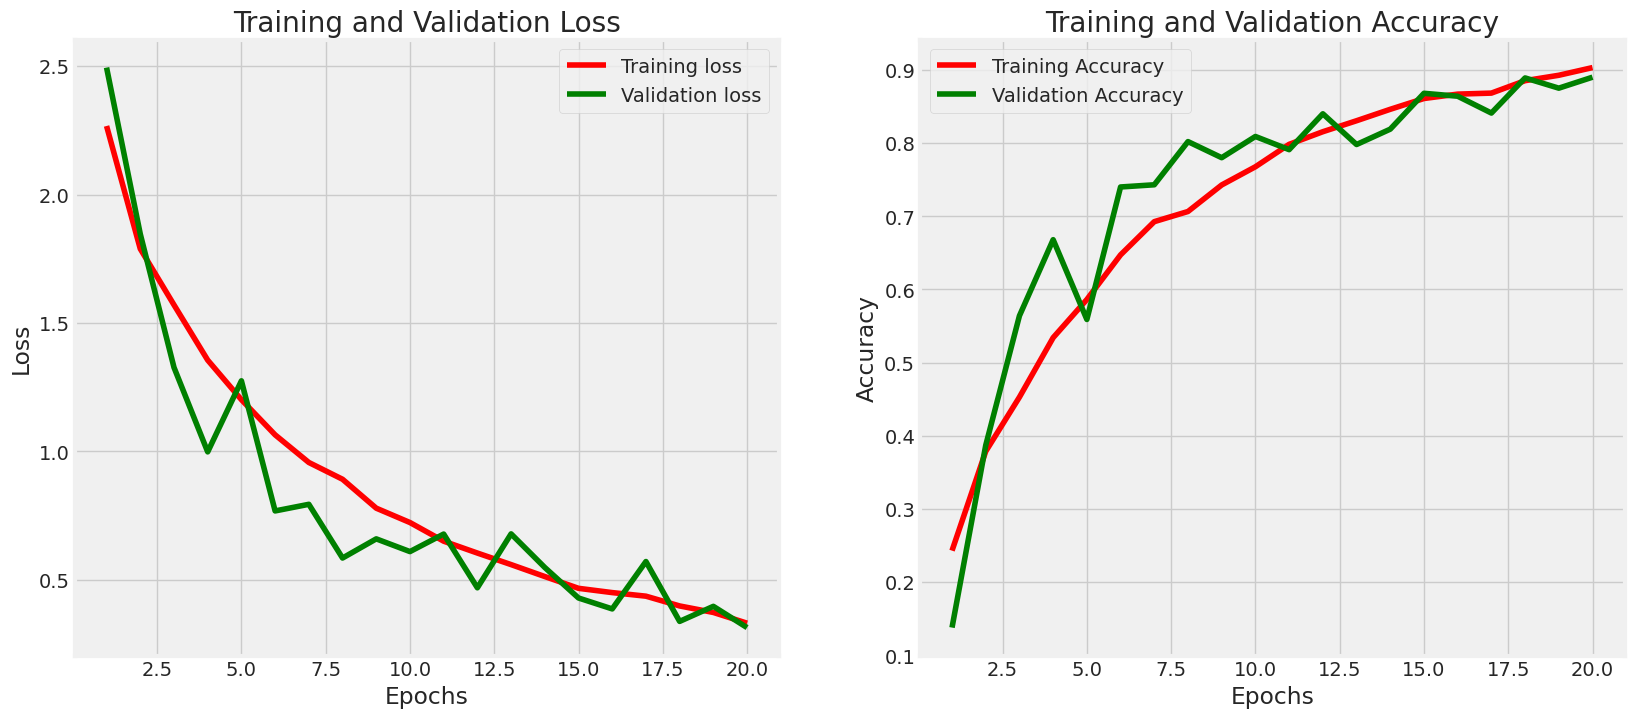

In [23]:
model_performance(history, epochs)

In [24]:
model_evaluation(cnn_model)

500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.9282 - loss: 0.2209
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8780 - loss: 0.3477
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.8862 - loss: 0.3514
Train Loss:  0.22965805232524872
Train Accuracy:  0.9244999885559082
--------------------
Validation Loss:  0.3181512653827667
Validation Accuracy:  0.8899999856948853
--------------------
Test Loss:  0.3344920575618744
Test Accuracy:  0.8989999890327454


 6/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step

W0000 00:00:1738848659.220539      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step


W0000 00:00:1738848662.202578      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


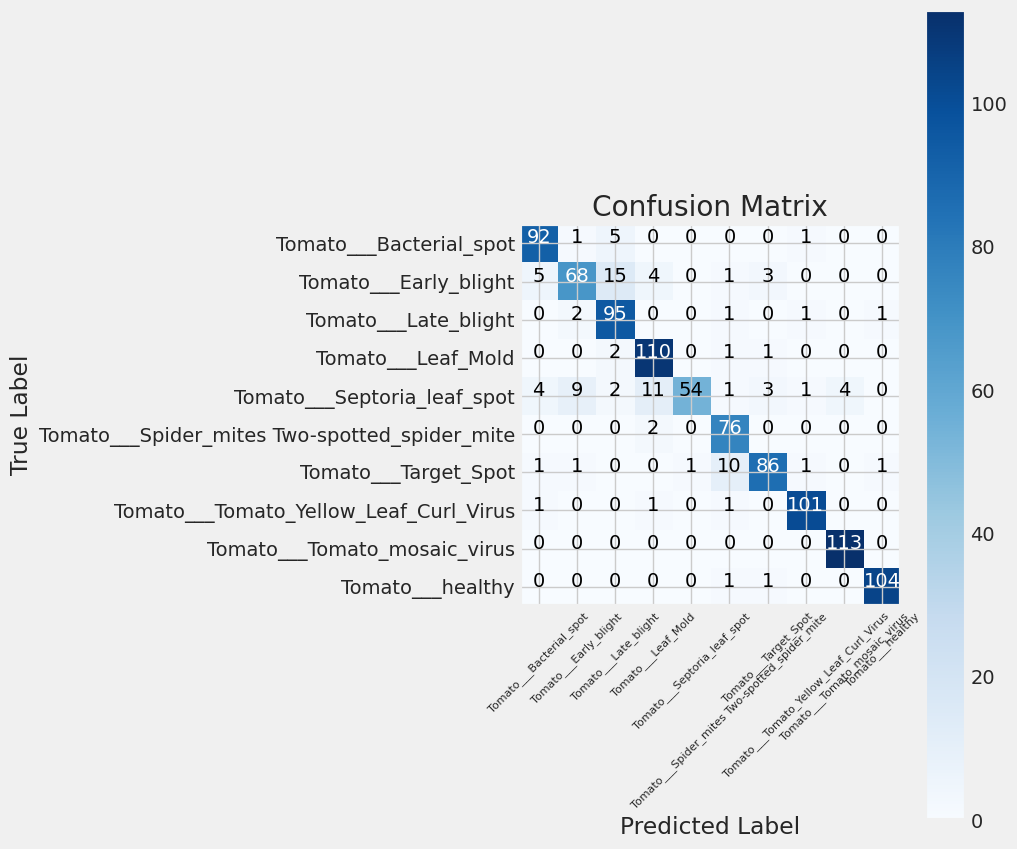

In [25]:
y_pred = get_pred(cnn_model, test_gen)

plot_confusion_matrix(test_gen, y_pred)

In [26]:
from sklearn.metrics import classification_report

# Get true labels
y_true = test_gen.classes

# Print classification report
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.89      0.93      0.91        99
           1       0.84      0.71      0.77        96
           2       0.80      0.95      0.87       100
           3       0.86      0.96      0.91       114
           4       0.98      0.61      0.75        89
           5       0.83      0.97      0.89        78
           6       0.91      0.85      0.88       101
           7       0.96      0.97      0.97       104
           8       0.97      1.00      0.98       113
           9       0.98      0.98      0.98       106

    accuracy                           0.90      1000
   macro avg       0.90      0.89      0.89      1000
weighted avg       0.90      0.90      0.90      1000



# EfficientNetB3 Model Building

In [27]:

base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape = img_shape, pooling= None)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = dense_block(128, 0.5)(x)
x = dense_block(32, 0.2)(x)
predictions = Dense(class_counts, activation = "softmax")(x)    # output layer with softmax activation


EfficientNetB3_model = Model(inputs = base_model.input, outputs = predictions)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [28]:
EfficientNetB3_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

EfficientNetB3_model.summary()

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_10[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 10,991,513 (41.93 MB)

 Trainable params: 10,900,818 (41.58 MB)

 Non-trainable params: 90,695 (354.28 KB)

In [29]:
epochs = 20   

EfficientNetB3_history = EfficientNetB3_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/20
  1/500 ━━━━━━━━━━━━━━━━━━━━ 23:20:27 168s/step - accuracy: 0.0000e+00 - loss: 3.0762

W0000 00:00:1738849075.811790      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.1882 - loss: 2.5184

W0000 00:00:1738849157.812655      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


500/500 ━━━━━━━━━━━━━━━━━━━━ 266s 196ms/step - accuracy: 0.1884 - loss: 2.5177 - val_accuracy: 0.1590 - val_loss: 2.3701
Epoch 2/20


W0000 00:00:1738849173.782809      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


500/500 ━━━━━━━━━━━━━━━━━━━━ 76s 151ms/step - accuracy: 0.5114 - loss: 1.4490 - val_accuracy: 0.8160 - val_loss: 0.8191
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 75s 150ms/step - accuracy: 0.6877 - loss: 1.0300 - val_accuracy: 0.8940 - val_loss: 0.5587
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 75s 149ms/step - accuracy: 0.7858 - loss: 0.8038 - val_accuracy: 0.9260 - val_loss: 0.4029
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 74s 149ms/step - accuracy: 0.8308 - loss: 0.6596 - val_accuracy: 0.9560 - val_loss: 0.3114
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 74s 149ms/step - accuracy: 0.8799 - loss: 0.5286 - val_accuracy: 0.9680 - val_loss: 0.2318
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 74s 148ms/step - accuracy: 0.8961 - loss: 0.4629 - val_accuracy: 0.9750 - val_loss: 0.1855
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 74s 148ms/step - accuracy: 0.9179 - loss: 0.4045 - val_accuracy: 0.9770 - val_loss: 0.1524
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 74s 148ms/step - accuracy: 0.9329 - loss: 0.3524 - val

# EfficientNetB3 Model Performance - Prediction

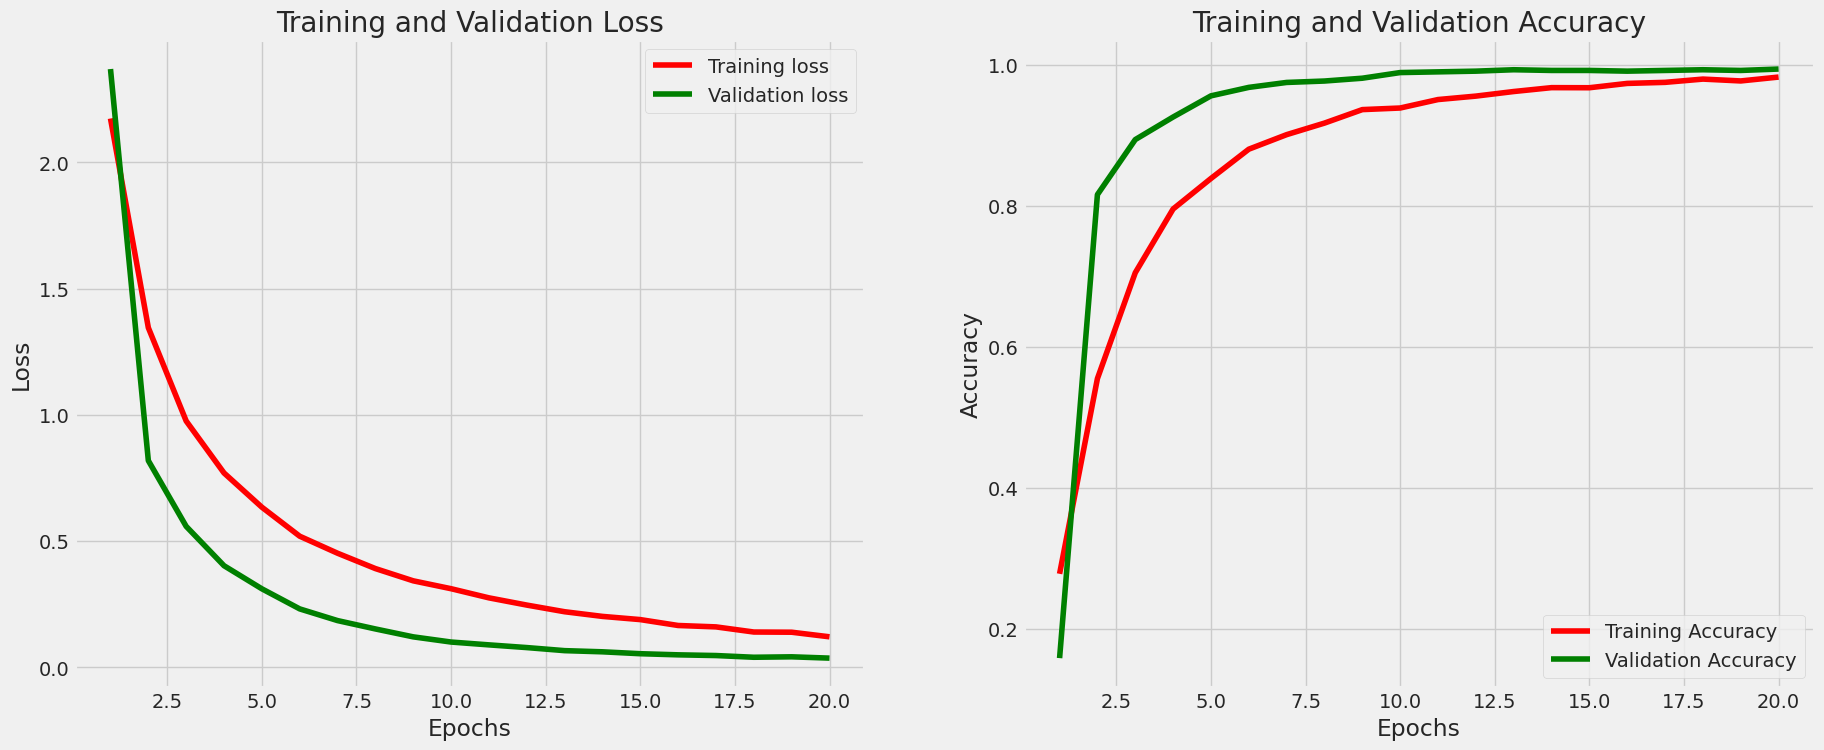

In [30]:
model_performance(EfficientNetB3_history, epochs)

In [31]:
model_evaluation(EfficientNetB3_model)

500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9999 - loss: 0.0148
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9938 - loss: 0.0395
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9935 - loss: 0.0502
Train Loss:  0.01490981038659811
Train Accuracy:  0.999875009059906
--------------------
Validation Loss:  0.03681614249944687
Validation Accuracy:  0.9940000176429749
--------------------
Test Loss:  0.05913402512669563
Test Accuracy:  0.9940000176429749


 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step

W0000 00:00:1738850646.918022      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 173ms/step


W0000 00:00:1738850657.629927      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


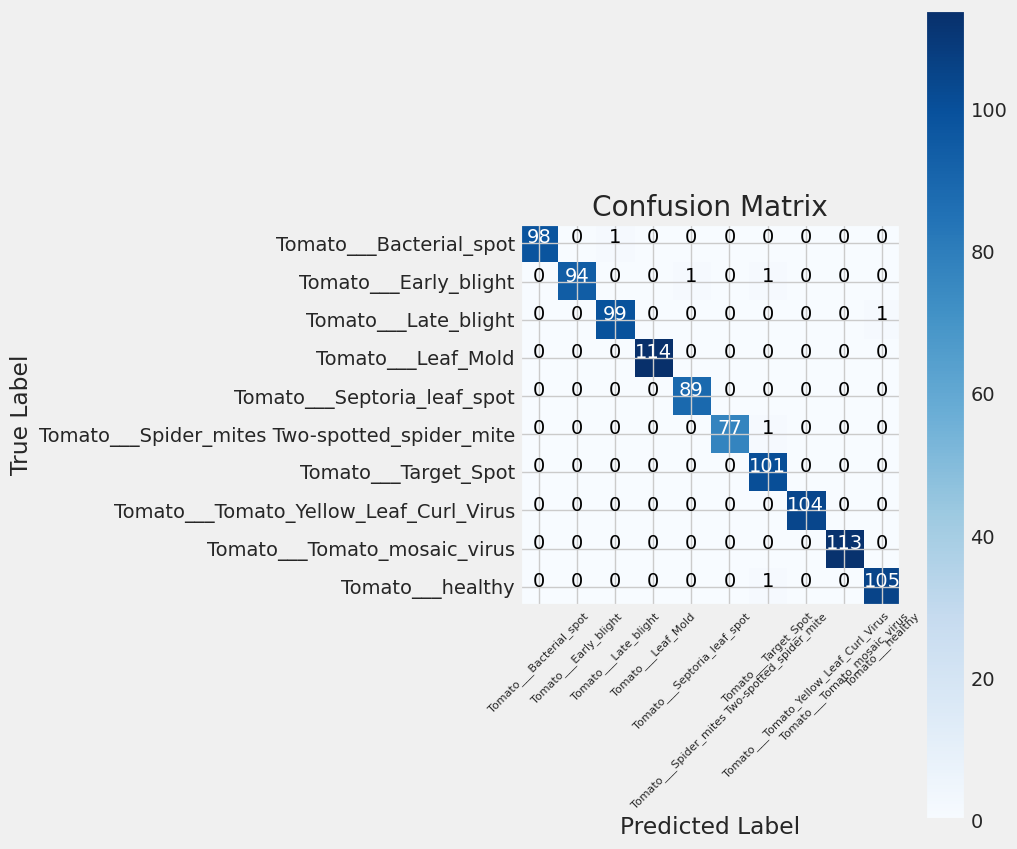

In [32]:
y_pred = get_pred(EfficientNetB3_model, test_gen)


plot_confusion_matrix(test_gen, y_pred)

In [34]:
from sklearn.metrics import classification_report

# Get true labels
y_true = test_gen.classes

# Print classification report
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.99      0.99        99
           1       1.00      0.98      0.99        96
           2       0.99      0.99      0.99       100
           3       1.00      1.00      1.00       114
           4       0.99      1.00      0.99        89
           5       1.00      0.99      0.99        78
           6       0.97      1.00      0.99       101
           7       1.00      1.00      1.00       104
           8       1.00      1.00      1.00       113
           9       0.99      0.99      0.99       106

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



# VGG16 Model

In [35]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape = img_shape, pooling= 'max')

for layer in base_model.layers[:15]:
    layer.trainable = False
    
    

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.2)(x)   # # Dropout layer to prevent overfitting
x = Dense(256, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dense(32, activation = 'relu')(x)
predictions = Dense(class_counts, activation = "sigmoid")(x)    # output layer with softmax activation


VGG16_model = Model(inputs = base_model.input, outputs = predictions)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [36]:
for layer in VGG16_model.layers:
    print(layer.name, layer.trainable)

input_layer_13 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
global_max_pooling2d True
flatten_1 True
dense_8 True
dropout_6 True
dense_9 True
dense_10 True
dense_11 True
dense_12 True


In [37]:
VGG16_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

VGG16_model.summary()

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,146,026 (57.78 MB)

 Trainable params: 7,510,762 (28.65 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [38]:
epochs = 20   

VGG16_history = VGG16_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/20
  2/500 ━━━━━━━━━━━━━━━━━━━━ 45s 92ms/step - accuracy: 0.1250 - loss: 0.7851   

W0000 00:00:1738850795.268358      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.2241 - loss: 0.5014

W0000 00:00:1738850837.359589      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


500/500 ━━━━━━━━━━━━━━━━━━━━ 79s 113ms/step - accuracy: 0.2244 - loss: 0.5011 - val_accuracy: 0.6650 - val_loss: 0.1708
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 90ms/step - accuracy: 0.6904 - loss: 0.1680 - val_accuracy: 0.8230 - val_loss: 0.1103
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 90ms/step - accuracy: 0.8081 - loss: 0.1130 - val_accuracy: 0.8840 - val_loss: 0.0783
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 48s 96ms/step - accuracy: 0.8845 - loss: 0.0800 - val_accuracy: 0.9060 - val_loss: 0.0623
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 91ms/step - accuracy: 0.9178 - loss: 0.0591 - val_accuracy: 0.9300 - val_loss: 0.0488
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 90ms/step - accuracy: 0.9437 - loss: 0.0454 - val_accuracy: 0.9250 - val_loss: 0.0506
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 90ms/step - accuracy: 0.9570 - loss: 0.0349 - val_accuracy: 0.9360 - val_loss: 0.0409
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 90ms/step - accuracy: 0.9684 - loss: 0.0278 - val_accura

# VGG16 Model Performance - Prediction

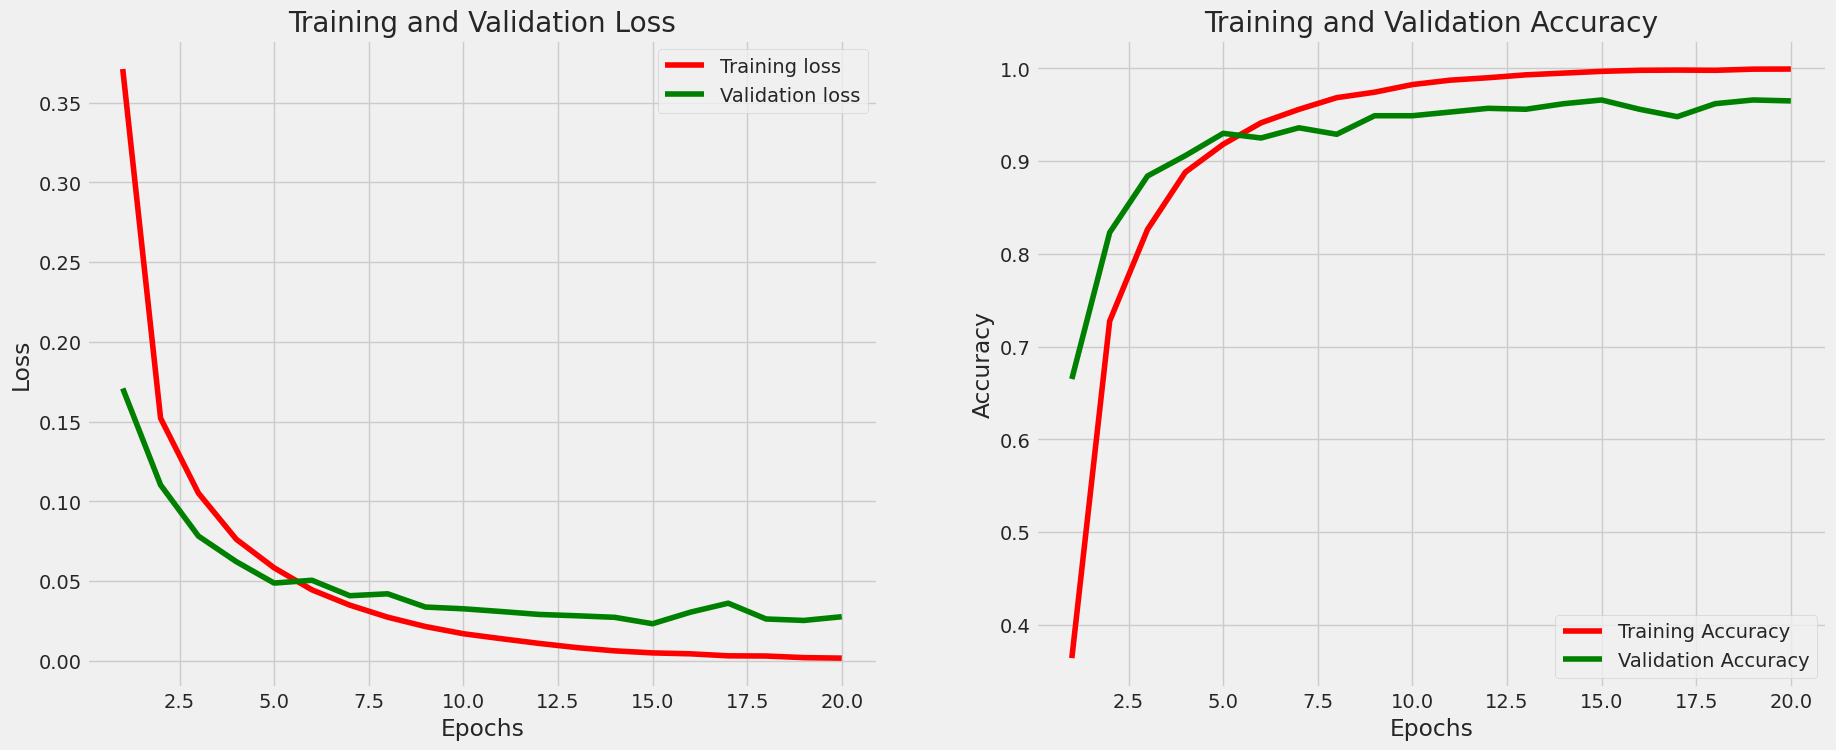

In [39]:
model_performance(VGG16_history, epochs)

In [40]:
model_evaluation(VGG16_model)

500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 90ms/step - accuracy: 1.0000 - loss: 6.9318e-04
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.9626 - loss: 0.0275
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9318 - loss: 0.0412
Train Loss:  0.0006937800208106637
Train Accuracy:  1.0
--------------------
Validation Loss:  0.02725077234208584
Validation Accuracy:  0.9649999737739563
--------------------
Test Loss:  0.04300738871097565
Test Accuracy:  0.9350000023841858


 3/63 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step 

W0000 00:00:1738851857.673130      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step


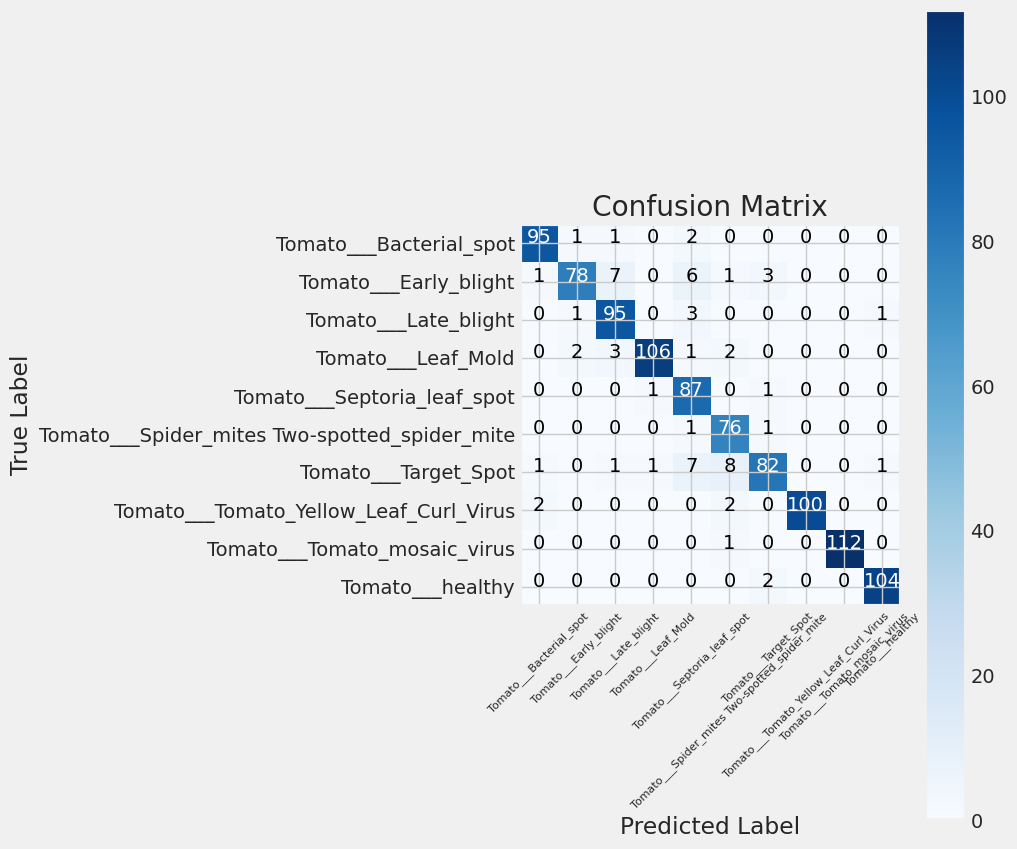

In [41]:
y_pred = get_pred(VGG16_model, test_gen)

plot_confusion_matrix(test_gen, y_pred)

In [42]:
from sklearn.metrics import classification_report

# Get true labels
y_true = test_gen.classes

# Print classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        99
           1       0.95      0.81      0.88        96
           2       0.89      0.95      0.92       100
           3       0.98      0.93      0.95       114
           4       0.81      0.98      0.89        89
           5       0.84      0.97      0.90        78
           6       0.92      0.81      0.86       101
           7       1.00      0.96      0.98       104
           8       1.00      0.99      1.00       113
           9       0.98      0.98      0.98       106

    accuracy                           0.94      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.94      0.94      0.94      1000



In [45]:
def evaluate_model(model, model_name, test_gen):
    y_pred = get_pred(model, test_gen)  # Get predictions
    y_true = test_gen.classes  # True labels
    
    # Check if predictions are probabilities or labels
    if len(y_pred.shape) > 1:  # If predictions are in probability format
        y_pred_labels = np.argmax(y_pred, axis=1)  # Convert to class labels
    else:  # If predictions are already class labels
        y_pred_labels = y_pred

    print(f"\n===== {model_name} =====")
    print("Accuracy:", accuracy_score(y_true, y_pred_labels))
    print(classification_report(y_true, y_pred_labels))

# Evaluate all three models
evaluate_model(cnn_model, "CNN", test_gen)
evaluate_model(EfficientNetB3_model, "EfficientNetB3", test_gen)
evaluate_model(VGG16_model, "VGG16", test_gen)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step

===== CNN =====
Accuracy: 0.899
              precision    recall  f1-score   support

           0       0.89      0.93      0.91        99
           1       0.84      0.71      0.77        96
           2       0.80      0.95      0.87       100
           3       0.86      0.96      0.91       114
           4       0.98      0.61      0.75        89
           5       0.83      0.97      0.89        78
           6       0.91      0.85      0.88       101
           7       0.96      0.97      0.97       104
           8       0.97      1.00      0.98       113
           9       0.98      0.98      0.98       106

    accuracy                           0.90      1000
   macro avg       0.90      0.89      0.89      1000
weighted avg       0.90      0.90      0.90      1000

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step

===== EfficientNetB3 =====
Accuracy: 0.994
              precision    recall  f1-score   support

           0       1.00      

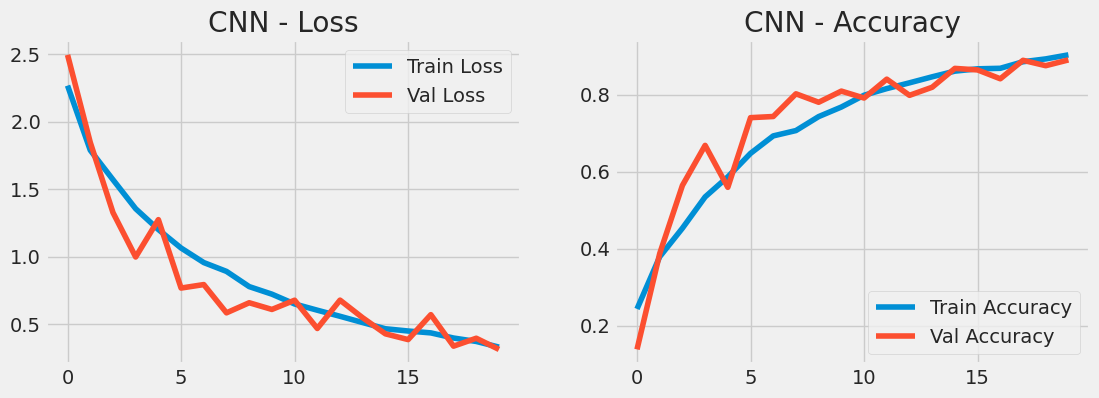

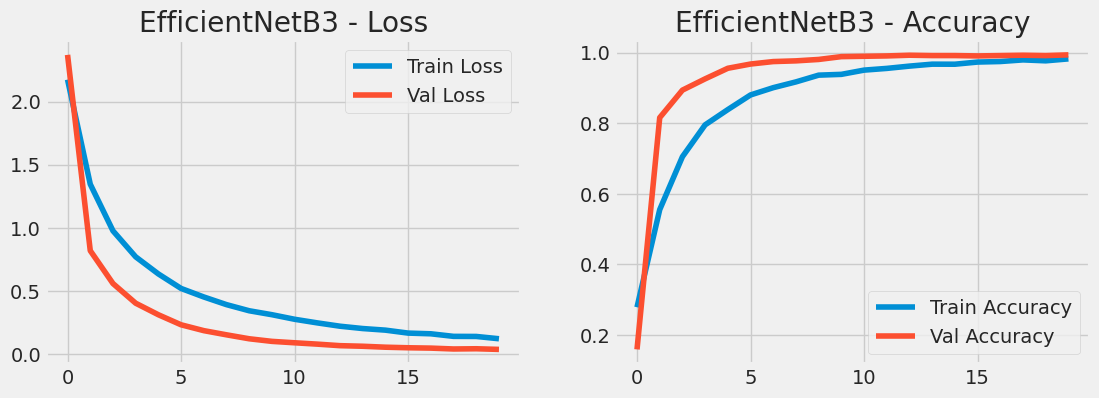

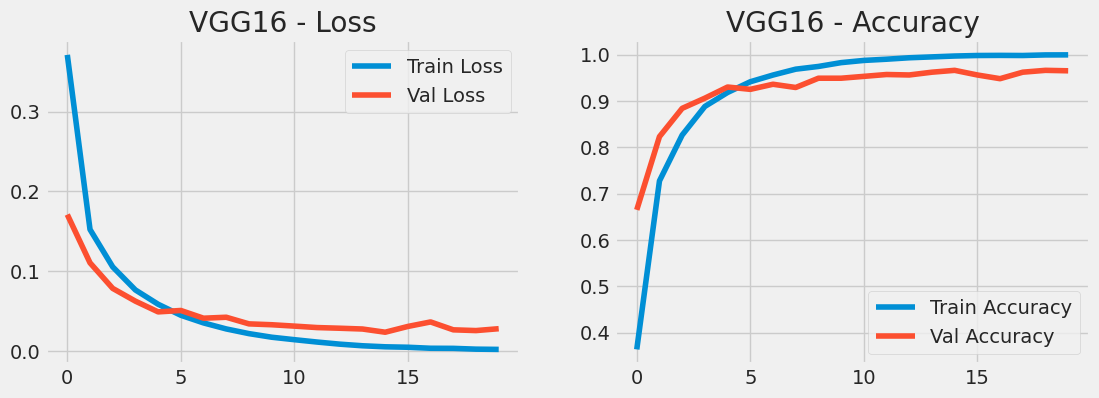

In [48]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(history, model_name):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot Loss
    axes[0].plot(history.history['loss'], label='Train Loss')
    axes[0].plot(history.history['val_loss'], label='Val Loss')
    axes[0].set_title(f'{model_name} - Loss')
    axes[0].legend()
    
    # Plot Accuracy
    axes[1].plot(history.history['accuracy'], label='Train Accuracy')
    axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[1].set_title(f'{model_name} - Accuracy')
    axes[1].legend()

    plt.show()

# Assuming you have the training history of each model
plot_loss_accuracy(history, "CNN")
plot_loss_accuracy(EfficientNetB3_history, "EfficientNetB3")
plot_loss_accuracy(VGG16_history, "VGG16")


In [52]:
import time

def measure_inference_time(model, test_gen, model_name):
    start_time = time.time()
    _ = get_pred(model, test_gen)
    end_time = time.time()
    
    print(f"{model_name} Inference Time: {end_time - start_time:.4f} seconds")

measure_inference_time(cnn_model, test_gen, "CNN")
measure_inference_time(EfficientNetB3_model, test_gen, "EfficientNetB3")
measure_inference_time(VGG16_model, test_gen, "VGG16")


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
CNN Inference Time: 2.1914 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
EfficientNetB3 Inference Time: 2.4065 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step
VGG16 Inference Time: 4.4408 seconds
